In [1]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})
plt.rc('font', family='arial')

# pip install pycairo

# uncomment to get better editable text boxes if saving files as pdfs and importing to illustrator
# import matplotlib
# matplotlib.use('cairo')

import matplotlib.font_manager as fm
font = fm.FontProperties(family = 'arial')
# e.g., 
# plt.title('Single Component', fontproperties = font)

In [2]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [3]:
from get_windows import get_windows_with_GC_content_and_cpg_islands 

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi
0,chr1,1432000,1433000,4.299894,259,True,False,0.653,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False,338.059552
1,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657
2,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925
3,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243
4,chr1,1463000,1464000,2.948188,191,True,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False,236.321790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,302,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True,263.131293
1019147,chr9,137268000,137269000,3.640544,212,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False,272.046527
1019148,chr9,137269000,137270000,5.276351,209,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False,300.458958
1019149,chr9,137275000,137276000,2.687348,290,True,False,0.536,1.564889,0.024254,...,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False,339.517045


## Baseline classifier

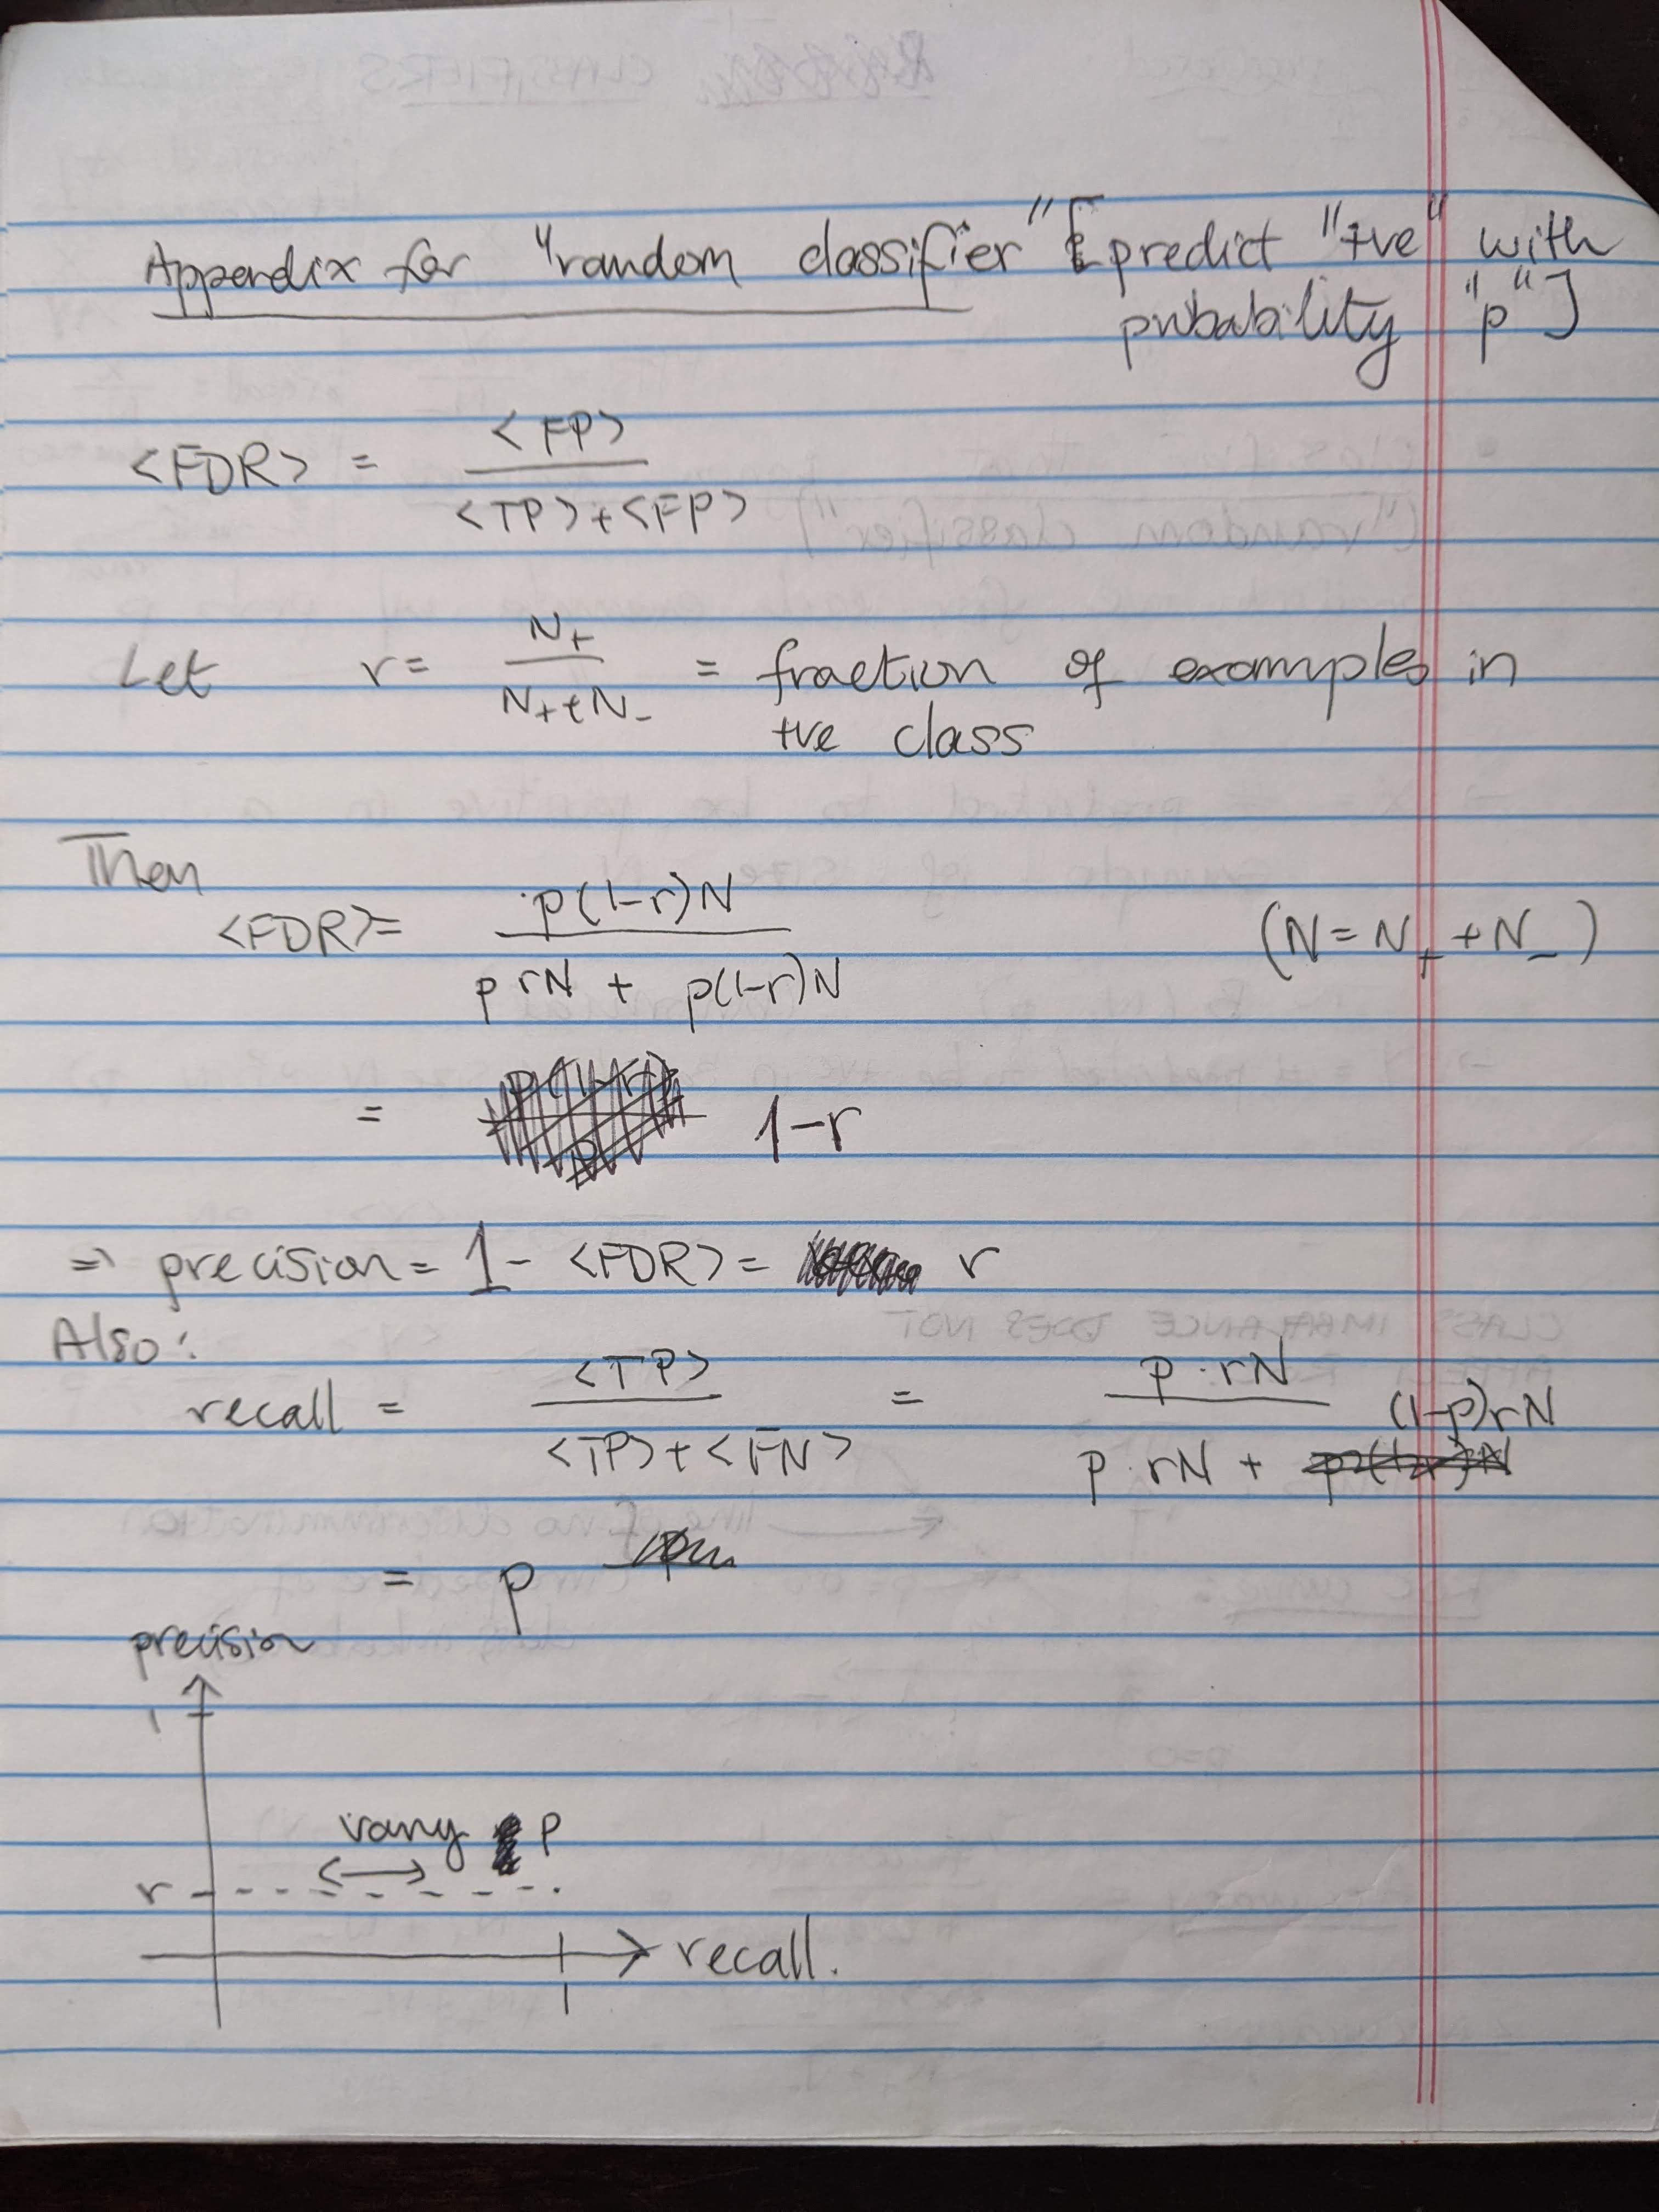

In [4]:
from IPython.display import Image # type: ignore
Image(filename='precision_recall_random_classifier.jpg', width=600)

## Features that negatively impact a Gnocchi-based classifier

GC_content_1000bp: (0.3855522819856123, 0.4223190176726326)
B_M1star.EUR: (0.23312384366208225, 0.39194030697055426)
B: (0.7791188082310888, 0.8516373073984892)
1019151


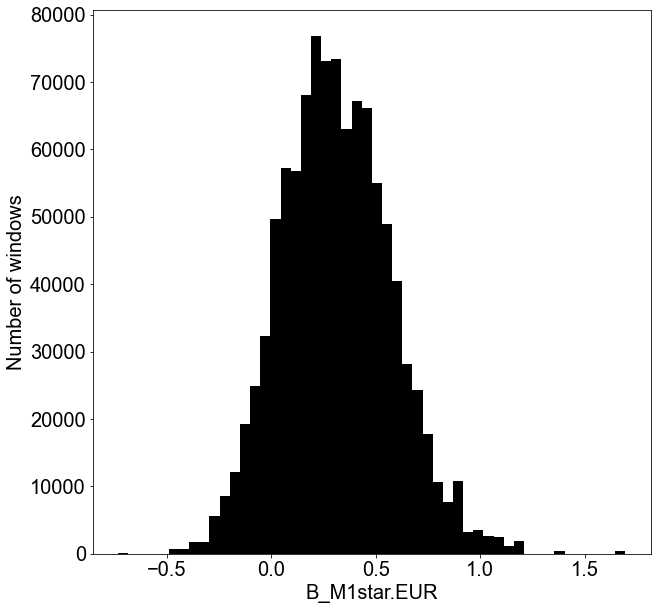

(-0.385, -0.0383]
(-0.0383, 0.308]
(0.308, 0.655]
(0.655, 1.001]
(1.001, 1.348]


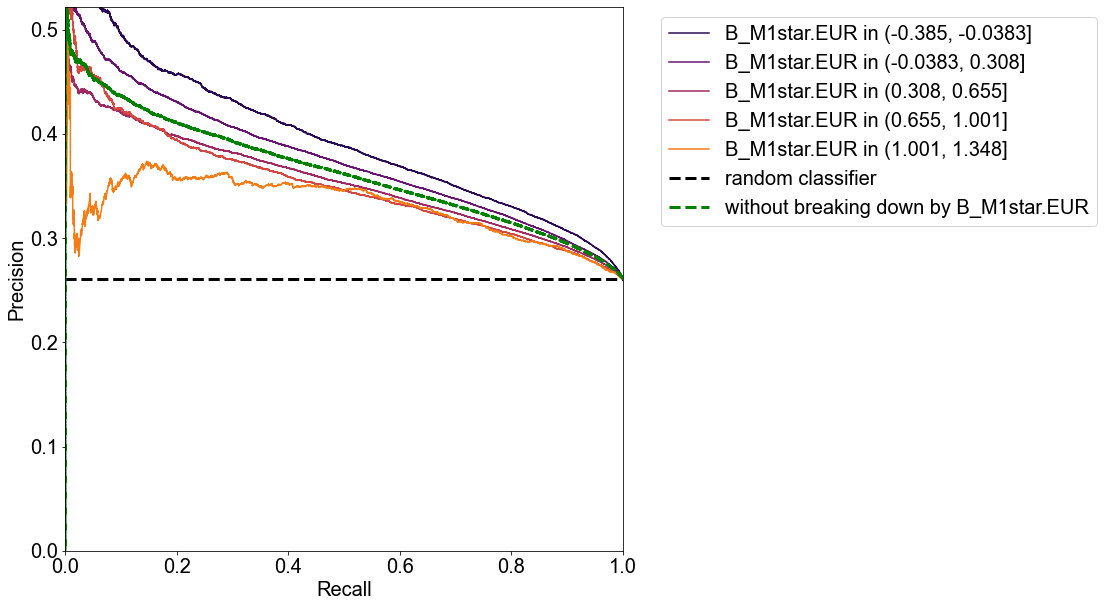

GC_content_1000bp: (0.3855522819856123, 0.4223190176726326)
B_M1star.EUR: (0.23312384366208225, 0.39194030697055426)
B: (0.7791188082310888, 0.8516373073984892)
conditioning on GC_content_1000bp in [0.3855522819856123, 0.4223190176726326]
conditioning on B in [0.7791188082310888, 0.8516373073984892]
48531


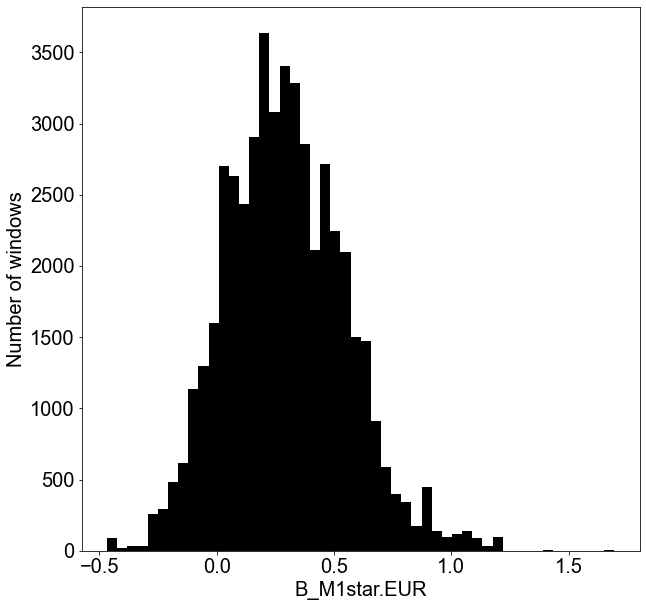

(-0.158, 0.151]
(0.151, 0.459]
(0.459, 0.768]


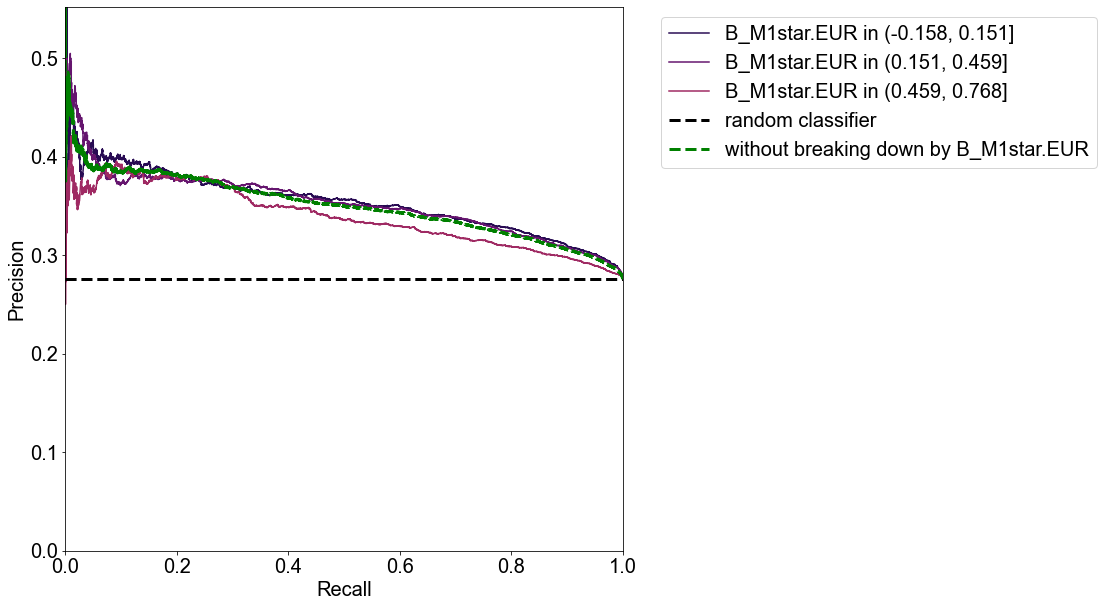

In [62]:
import matplotlib.cm as cm
from sklearn.metrics import precision_recall_curve
import pandas as pd
import importlib

import util
importlib.reload(util)
from util import (
  length_to_string, 
  compute_limits as _compute_limits, 
  slice_feature_space,
)

# this is "r" in the baseline-classifier theory: 
def compute_positive_fraction(df, target):
  value_counts = df[target].value_counts()
  number_negative_examples = value_counts.get(False, 0)
  number_positive_examples = value_counts.get(True, 0)
  return number_positive_examples / (number_negative_examples + number_positive_examples)

def plot_random_classifier(df, target, color, axis):
  r = compute_positive_fraction(df, target)
  axis.plot([0, 1], [r, r], linestyle='--', linewidth=3, color=color, label='random classifier')  

def downsample(df, group_columns, target):
  positive_class_sizes = df.groupby(group_columns)[target].apply(lambda ser: ser.value_counts().get(True, 0))
  negative_class_sizes = df.groupby(group_columns)[target].apply(lambda ser: ser.value_counts().get(False, 0))  
  positive_to_negative_ratios = positive_class_sizes/negative_class_sizes
  min_positive_to_negative_ratio = positive_to_negative_ratios.min()

  def downsample_positive_class(group):
    negative_class = group[group[target] == False]
    negative_class_size = len(negative_class)
    positive_class = group[group[target] == True]
    new_positive_class_size = int(min_positive_to_negative_ratio*negative_class_size)
    positive_class_downsampled = positive_class.sample(new_positive_class_size)
    return pd.concat([positive_class_downsampled, negative_class])
  
  df_downsampled = df.groupby(group_columns).apply(downsample_positive_class).reset_index(drop=True)
  return df_downsampled

def preprocess(df, feature, target, number_bins): 
  df = df.copy() 
  df[f'{feature}_bin'] = pd.cut(df[f'{feature}'], bins=number_bins) 
  df = downsample(
    df, 
    group_columns=[f'{feature}_bin'], 
    target=target
  )
  return df 

def get_GC_mean_factor(gc_window_size): 
  if gc_window_size == 1000: 
    return 1
  elif gc_window_size == 1000000:
    return 0.975
  else:
    raise ValueError(f'invalid GC window size: {gc_window_size}')
                     
def get_GC_std_factor(gc_window_size): 
  if gc_window_size == 1000: 
    return 0.3
  elif gc_window_size == 1000000:
    return 0.5
  else:
    raise ValueError(f'invalid GC window size: {gc_window_size}')
  
def compute_center_limits(df, feature, mean_factor, std_factor):
  return _compute_limits(df, feature, mean_factor, std_factor)

def get_GC_feature_lims_label(df, gc_window_size): 
  return ( 
    f'GC_content_{gc_window_size}bp', 
    compute_center_limits(
      df, 
      f'GC_content_{gc_window_size}bp', 
      mean_factor=get_GC_mean_factor(gc_window_size), 
      std_factor=get_GC_std_factor(gc_window_size)
    ), 
    f'GC_content ({length_to_string(gc_window_size)})'
  )

def get_features_and_lims_and_labels(df, gc_window_size): 
  features_and_lims_and_labels = [
    get_GC_feature_lims_label(df, gc_window_size),
    (
      'B_M1star.EUR', 
      compute_center_limits(
        df, 
        'B_M1star.EUR', 
        mean_factor=1, 
        std_factor=0.3
      ), 
      'gBGC'
    ),
    (
      'B', 
      compute_center_limits(
        df, 
        'B', 
        mean_factor=1, 
        std_factor=0.3
      ), 
      'BGS'
    ),
  ]

  for f, cl, _ in features_and_lims_and_labels: 
    print(f'{f}: {cl}')

  return features_and_lims_and_labels 

def plot_feature_distribution(df, feature): 
  fig, ax = plt.subplots(figsize=(10, 10))
  plt.hist(df[feature], bins=50, color='black')
  ax.set_xlabel(feature)
  ax.set_ylabel('Number of windows')
  ax.grid(False)
  plt.show()

def plot_precision_recall_all_bins(df, feature, number_bins, constraint_score, target, ylim): 
  plot_feature_distribution(df, feature)
  
  df = preprocess(df, feature, target, number_bins)

  fig, ax = plt.subplots(figsize=(10, 10))
  cmap = cm.get_cmap('inferno')

  for i, feature_bin in enumerate(sorted(df[f'{feature}_bin'].unique())): 
    df_bin = df[df[f'{feature}_bin'] == feature_bin]
    if len(df_bin) < 5000: continue
    print(feature_bin)
    color = cmap(i / number_bins)
    targets, scores = df_bin[target], df_bin[constraint_score]
    precision, recall, _ = precision_recall_curve(targets, scores)
    plt.plot(recall, precision, color=color, linestyle='-', label=f'{feature} in {feature_bin}')

  r = compute_positive_fraction(df, target)

  plot_random_classifier(
    df, 
    target, 
    color='black', 
    axis=ax,
  )
  
  # plot performance of classifier without breaking down by feature
  targets, scores = df[target], df[constraint_score]
  precision, recall, _ = precision_recall_curve(targets, scores)
  plt.plot(recall, precision, color='green', linewidth=3, linestyle='--', label=f'without breaking down by {feature}')

  ax.grid(False)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.set_xlim(0, 1)
  if not ylim: 
    ax.set_ylim(0, 2*r)
  else: 
    ax.set_ylim(ylim)
  plt.show()

def plot_precision_recall_with_and_without_slicing(df, gc_window_size, feature, number_bins, constraint_score='gnocchi', target='window overlaps enhancer', ylim=None): 
  assert feature in [f for f, _, _, in get_features_and_lims_and_labels(df, gc_window_size)]

  print(len(df))
  plot_precision_recall_all_bins(df, feature, number_bins, constraint_score, target, ylim)

  conditional_features_and_center_lims = [
    (f, cl) for f, cl, _ in get_features_and_lims_and_labels(df, gc_window_size) if f != feature
  ]
  df = slice_feature_space(df, conditional_features_and_center_lims)
  print(len(df))
  plot_precision_recall_all_bins(df, feature, number_bins, constraint_score, target, ylim)

# plot_precision_recall_with_and_without_slicing(WINDOWS, gc_window_size=1000, feature='GC_content_1000bp', number_bins=6)
# plot_precision_recall_with_and_without_slicing(WINDOWS, gc_window_size=1000000, feature='GC_content_1000000bp', number_bins=8)
# plot_precision_recall_with_and_without_slicing(WINDOWS, gc_window_size=1000, feature='B', number_bins=6)
plot_precision_recall_with_and_without_slicing(WINDOWS, gc_window_size=1000, feature='B_M1star.EUR', number_bins=7)

In [63]:
# TODO: try to plot more lines on each plot above

## [TODO] Comparing the impact of different features on a Gnocchi-based classifier

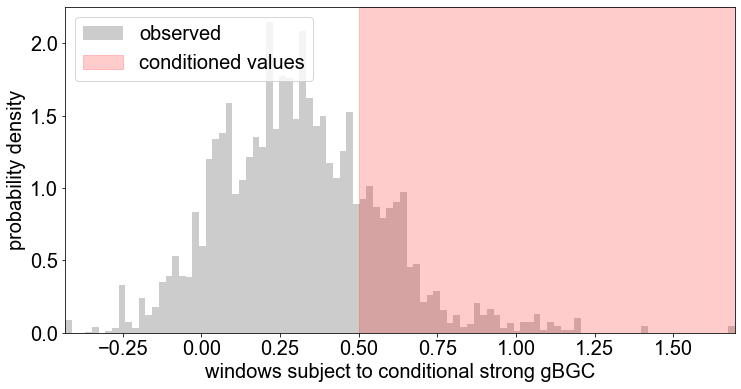

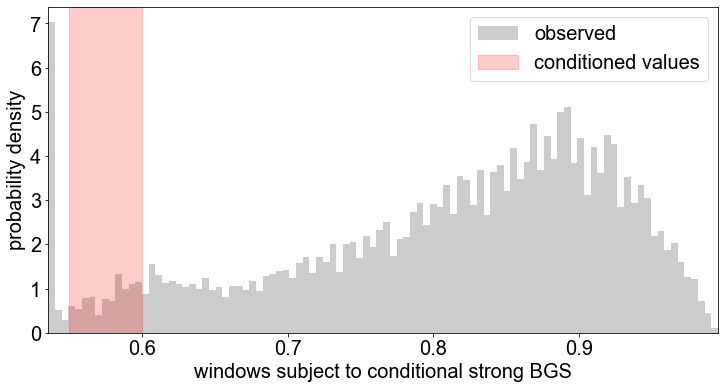

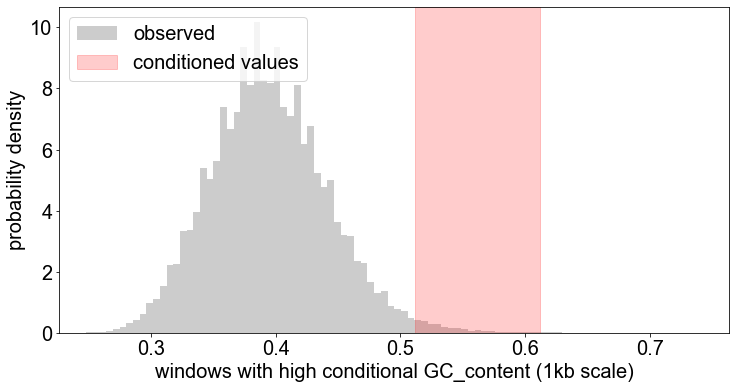

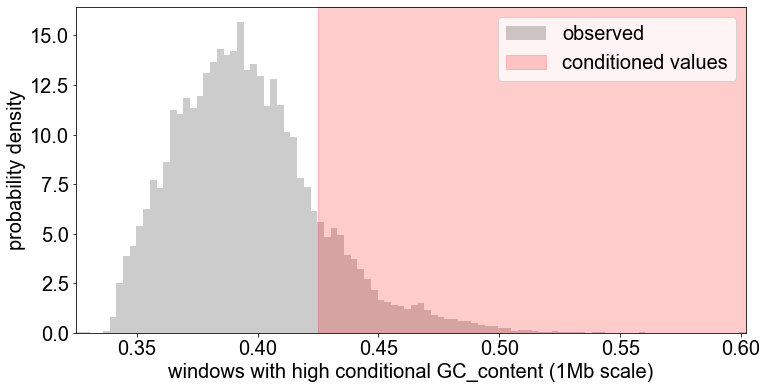

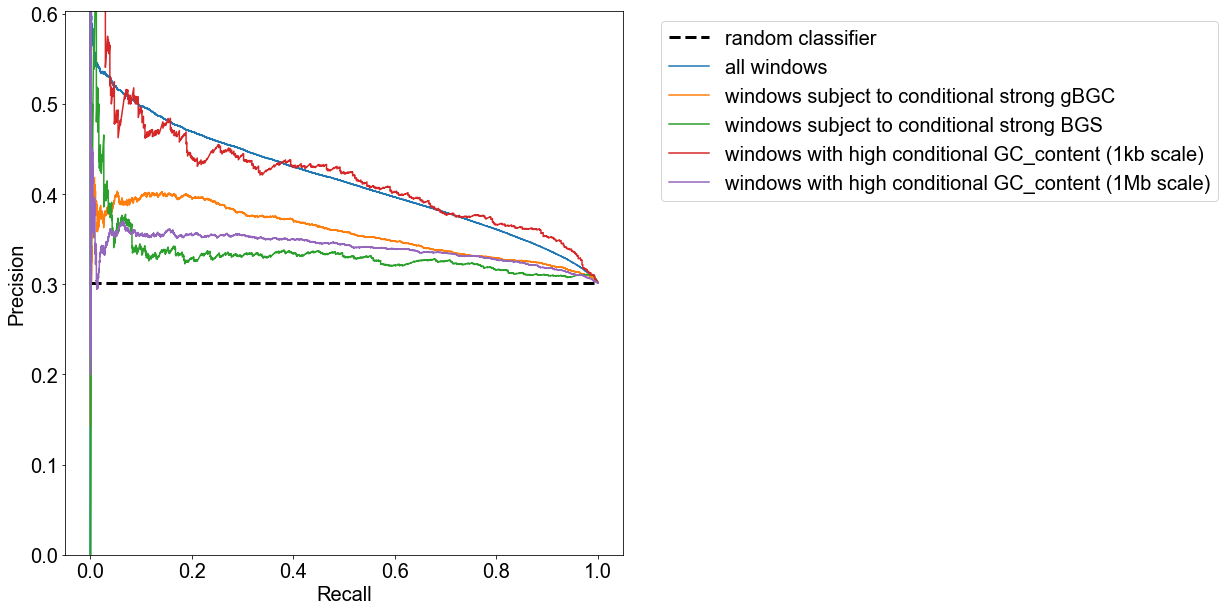

In [21]:
def get_subset(df, feature, feature_min, feature_max, target): 
  subset = df[
    (df[feature] > feature_min) & 
    (df[feature] < feature_max)
  ]
  r = compute_positive_fraction(subset, target)
  return subset, r

def resample_subset(df, target, r, label):
  negative_class = df[df[target] == False]
  positive_class = df[df[target] == True]
  new_positive_class_size = int(r*len(negative_class)/(1-r))
  if new_positive_class_size > len(positive_class): 
    print(label)
    raise ValueError('new_positive_class_size > old_positive_class_size)')
  positive_class_downsampled = positive_class.sample(new_positive_class_size)
  df = pd.concat([positive_class_downsampled, negative_class])
  return df 

def compute_GC_tail_limits(gc_window_size):
  if gc_window_size == 1000: 
    return 0.512, 0.612
    # return 0.45, 0.8
  elif gc_window_size == 1000000:
    # return 0.444, 0.485
    return 0.425, 0.8
  else:
    raise ValueError(f'invalid GC window size: {gc_window_size}')

# TODO: refactor this to use similar function above: 
def get_feature_lims_label(df, gc_window_size): 
  return ( 
    f'GC_content_{gc_window_size}bp', 
    compute_center_limits(
      df, 
      f'GC_content_{gc_window_size}bp', 
      mean_factor=get_mean_factor(gc_window_size), 
      std_factor=get_std_factor(gc_window_size)
    ), 
    compute_GC_tail_limits(gc_window_size),
    f'windows with high conditional GC_content ({length_to_string(gc_window_size)} scale)'
  )

def plot_precision_recall_all_features(df, target='window overlaps enhancer', constraint_score='gnocchi'):
  subsets_and_labels, rs = [], []

  subsets_and_labels.append((df, 'all windows'))
  rs.append(compute_positive_fraction(df, target))

  # TODO: refactor this to use similar code above: 
  features_and_lims_and_labels = [
    (
      'B_M1star.EUR', 
      compute_center_limits(
        df, 
        'B_M1star.EUR', 
        mean_factor=1, 
        std_factor=1#0.3
      ), 
      # (0.655, 1.001),
      (0.5, 2),
      'windows subject to conditional strong gBGC'
    ),
    (
      'B', 
      compute_center_limits(
        df, 
        'B', 
        mean_factor=1, 
        std_factor=1#0.3
      ), 
      # (0.536, 0.613),
      (0.55, 0.6),
      'windows subject to conditional strong BGS'
    ),
    get_feature_lims_label(df, gc_window_size=1000),
    get_feature_lims_label(df, gc_window_size=1000000),
  ]

  for feature, _, tail_lims, label in features_and_lims_and_labels:
    conditional_features_and_center_lims = [
      (f, cl) for f, cl, _, _ in features_and_lims_and_labels if f != feature
    ]
    df_sliced = slice_feature_space(df, conditional_features_and_center_lims)    
    plot_feature_distribution(df_sliced, feature, xlabel=label, lim=tail_lims)
    subset, r = get_subset(df_sliced, feature, tail_lims[0], tail_lims[1], target) 
    subsets_and_labels.append((subset, label))
    rs.append(r)
  
  r_min = min(rs)
  
  resampled_subsets_and_labels = [
    (resample_subset(subset, target, r_min, label), label)
    for subset, label in subsets_and_labels
  ]

  pr_curves_and_labels = [
    (precision_recall_curve(subset[target], subset[constraint_score]), label) # TODO: check allowed values for probas_pred arg of precision_recall_curve
    for subset, label in resampled_subsets_and_labels
  ]

  plt.figure(figsize=(10, 10))

  plt.plot([0, 1], [r_min, r_min], linestyle='--', linewidth=3, color='black', label='random classifier')  

  for pr_curve, label in pr_curves_and_labels:
    precision, recall, _ = pr_curve
    plt.plot(recall, precision, label=label)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  plt.ylim(0, 2*r_min)
  plt.show()

plot_precision_recall_all_features(WINDOWS)

In [14]:
# TODO: 
# define tail by quantiles 
# correct experiments/germline-model/chen-et-al-2022/assess-impact-of-featureXXX-on-Gnocchi-predictions-at-all-enhancers.ipynb

In [ ]:
# TODO?

# for each bin of (GC content, gBGC, BGS), compute auPRC/auPRC_random and plot as a heatmap
# fit a model to this mapping, and show that regression coefficients are largest for BGS 

In [ ]:
# TODO: 

# even though bias appears larger for GC, it's impact on FDR is comparable to other features. 
# this is because truly constrained regions co-vary with GC content.
# we can demonstrate that by plotting fraction of enhancers in bins of GC content, showing that enhancers are more likely in GC-rich regions,
# but not more likely in high gBGC and BGS regions! 

In [15]:
# TODO: 
# incorporate DR and lambda_s into Fig2.ipynb and create PR curves for Gnocchi, and DR and lambda_s
# then create Fig2.ai and put it in the doc
# finally, Fig3 will try to correct GC bias in Gnocchi 
